In [0]:
%tensorflow_version 2.x


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import keras
print(keras.__version__)
print(tf.__version__)

2.2.5
2.1.0


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
%matplotlib inline

# Loading data files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os

In [0]:
path_to_data = 'drive/My Drive/Colab Notebooks/'

In [ ]:
print(os.listdir(path_to_data))

In [0]:
df_read = pd.read_csv(os.path.join(path_to_data, 'protein_seq-cls.csv'), index_col=0)
df_read.drop_duplicates(subset='sequence', inplace=True)

In [0]:
dfp = pd.read_csv(os.path.join(path_to_data,'protein_cls.csv'),
                  index_col=0).reset_index(drop=True)

In [0]:
df_read[df_read['classification'] == 'hydrolase']['sequence'].values[0]

'TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMVVEIPRWTNAKLEITKEETLNPIIQDTKKGKLRFVRNCFPHHGYIHNYGAFPQTWEDPNVSHPETKAVGDNEPIDVLEIGETIAYTGQVKQVKALGIMALLDEGETDWKVIAIDINDPLAPKLNDIEDVEKYFPGLLRATNEWFRIYKIPDGKPENQFAFSGEAKNKKYALDIIKETHDSWKQLIAGKSSDSKGIDLTNVTLPDTPTYSKAASDAIPPASLKADAPIDKSIDKWFFISGSV'

In [0]:
dfp.nunique()

structureId                 74988
classification               1613
experimentalTechnique          22
residueCount                 3517
resolution                    537
structureMolecularWeight    74177
densityMatthews               619
densityPercentSol            5373
phValue                       302
sequence                    86469
label                        1613
lengths                      1306
dtype: int64

In [0]:
cols = list(df_read.columns)

In [0]:
df_merge = df_read.merge(dfp, on=['sequence', 'lengths', 'label', 'classification'], how='outer')

In [0]:
df_merge.nunique()

structureId_x               75006
classification               1613
sequence                    86690
lengths                      1307
label                        1613
structureId_y               74988
experimentalTechnique          22
residueCount                 3517
resolution                    537
structureMolecularWeight    74177
densityMatthews               619
densityPercentSol            5373
phValue                       302
dtype: int64

In [0]:
df_merge.drop_duplicates(subset='sequence', inplace=True)
df_merge1 = df_merge.groupby('classification').ffill()
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86690 entries, 0 to 87069
Data columns (total 12 columns):
structureId_x               86690 non-null object
sequence                    86690 non-null object
lengths                     86690 non-null int64
label                       86690 non-null int64
structureId_y               77522 non-null object
experimentalTechnique       77522 non-null object
residueCount                77522 non-null float64
resolution                  77522 non-null float64
structureMolecularWeight    77522 non-null float64
densityMatthews             77522 non-null float64
densityPercentSol           77522 non-null float64
phValue                     77522 non-null float64
dtypes: float64(6), int64(2), object(4)
memory usage: 8.6+ MB


In [0]:
df_merge2 = df_merge1.fillna(0)
df_merge2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86690 entries, 0 to 87069
Data columns (total 12 columns):
structureId_x               86690 non-null object
sequence                    86690 non-null object
lengths                     86690 non-null int64
label                       86690 non-null int64
structureId_y               86690 non-null object
experimentalTechnique       86690 non-null object
residueCount                86690 non-null float64
resolution                  86690 non-null float64
structureMolecularWeight    86690 non-null float64
densityMatthews             86690 non-null float64
densityPercentSol           86690 non-null float64
phValue                     86690 non-null float64
dtypes: float64(6), int64(2), object(4)
memory usage: 8.6+ MB


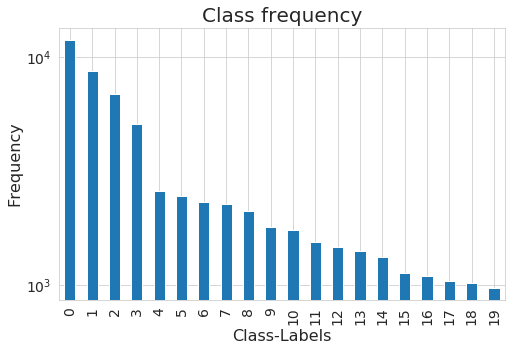

In [0]:
classes = df_merge.label.value_counts()
plt.figure(figsize=(8, 5))
classes[:20].plot(kind='bar')
plt.yscale('log')
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Class-Labels', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Class frequency', fontsize=20)
plt.show()

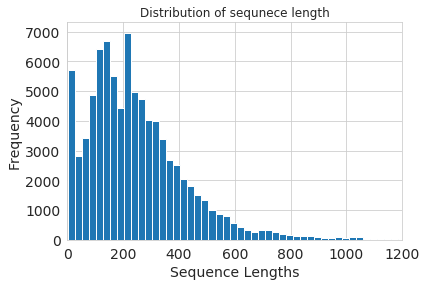

In [0]:
df_merge2.hist('lengths', bins=200)
plt.xlabel('Sequence Lengths', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, 1200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Distribution of sequnece length')
plt.show()

In [0]:
# Distribution of length shows that only small fraction of 
# total samples fall in the tail with longer than 800
# So, we select samples with shorter than 800
max_length = 1200
min_length = 2
df0 = df_merge2[(df_merge2['lengths'] >= min_length) & 
               (df_merge2['lengths'] <= max_length)]

In [0]:
name_classes = df_merge.classification.value_counts()
class_dictionary = dict()
counting = 0
contents = 1200 # Disregard the samples belonging to the 
                # family with total members less than 'contents'

for cat, num in name_classes.items():
    if num > contents:
      counting += 1
      class_dictionary[cat] = counting

class_dimension = len(class_dictionary)
print('Total classes: ', class_dimension)
class_dictionary

Total classes:  15


{'hydrolase': 1,
 'hydrolase/hydrolase inhibitor': 13,
 'immune system': 4,
 'isomerase': 12,
 'ligase': 14,
 'lyase': 6,
 'membrane protein': 15,
 'oxidoreductase': 3,
 'protein binding': 10,
 'signaling protein': 7,
 'structural genomics/unknown function': 8,
 'transcription': 5,
 'transferase': 2,
 'transport protein': 9,
 'viral protein': 11}

In [0]:

# Data left by discarding the samples longer than max_lengths and 
# shorter than min_lengths
print(str(round(100 * (len(df_merge2) - \
                       len(df0)) / len(df_merge2), 2))+'%')
print('Samples left: ', len(df0))

0.31%
Samples left:  86425


# Data Preprocessing


In [0]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [0]:
# Constructing the dictionary of protein superfamily classes and 
# total number of samples belonging to those classes
class_d = dict()
counting = 0
contents = 1200 # Disregard the samples belonging to the 
                # family with total members less than 'contents'

for cat, num in classes.items():
    if num > contents:
      counting += 1
      class_d[cat] = counting

class_dim = len(class_d)
print('Total classes: ', class_dim)

Total classes:  15


In [0]:
[i for i, j in class_d.items() if j == 4]

[3]

In [0]:
# List the selected classes:
top_classes = class_d.keys()
print('Total Classes: ', len(top_classes),
      '\nClasses:\n ', np.array(list(top_classes)))

Total Classes:  15 
Classes:
  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [0]:
# Data left by discarding the samples associated with certain families

df = df0[df0.label.isin(top_classes)].copy()
print(str(round((100 * (len(df0) - len(df))/len(df0)), 2))+'%')
len(df)

38.14%


53462

#### n-gram vectorization:
##### Tfidf vectorizer: <br> 
This vectorizer will convert the sequence into the vector of size equal to the size of the total 3-gram combination of 25 alphabets. This will create the featrue vectors of length equal to the total number of trigrams. Each letter in the sequence is replaced by the normalized frequency of the respective trigram made by adjacent letters.


In [0]:
t_vectorizer = TfidfVectorizer(analyzer='char',
                               ngram_range=(3,3),
                               max_features=5000,
                               sublinear_tf=True)
X = t_vectorizer.fit_transform(df['sequence'].values)
y = to_categorical(df['label'])

## Deep Learning Model

In [0]:
# Functions to plot the results:


def plot_confusion_matrix(cm1, cm2, classes,
                          saving_as,
                          normalize=False):
    if normalize:
        cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
        cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(cm1, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix\nTrain Set', fontsize=24)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    plt.grid(False)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm1.max() / 2
    #for i , j in itertools.product(range(cm.shape[0]),
        #                           range(cm.shape[1])):
        #plt.text(j, i, format(cm[i, j], fmt),
        #         color='white' if cm[i, j] >= thresh else 'black')
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xlim(tick_marks[0]-0.5, tick_marks[len(classes)-1]+0.5)
    plt.ylim(tick_marks[0]-0.5, tick_marks[len(classes)-1]+0.5)
    

    plt.subplot(1, 2, 2)
    plt.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix\nTest Set', fontsize=24)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm2.max() / 2
    #for i , j in itertools.product(range(cm.shape[0]),
        #                           range(cm.shape[1])):
        #plt.text(j, i, format(cm[i, j], fmt),
        #         color='white' if cm[i, j] >= thresh else 'black')
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xlim(tick_marks[0]-0.5, tick_marks[len(classes)-1]+0.5)
    plt.ylim(tick_marks[0]-0.5, tick_marks[len(classes)-1]+0.5)
    plt.colorbar(fraction=0.048, pad=0.05)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(saving_as)

In [0]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc', marker='o')
  plt.plot(x, val_acc, 'r', label='Validation acc', marker='s')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss', marker='o')
  plt.plot(x, val_loss, 'r', label='Validation loss', marker='s')
  plt.title('Training and validation loss')
  plt.legend()
  plt.savefig(os.path.join(path_to_data, 'loss-acc.pdf'))

In [0]:
# Importing required modules

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv1D
from tensorflow.python.keras.layers import MaxPooling1D, Flatten
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import itertools
from pandas import DataFrame

# from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras.layers import Bidirectional
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.python.keras.layers import TimeDistributed
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

### Vectorized matrices

In [0]:
sc = StandardScaler()
cols = list(['structureId_x', 'sequence', 'label', 'structureId_y', 'experimentalTechnique'])
Xpp = sc.fit_transform(df.drop(columns=cols))

In [0]:
XX = np.concatenate((X.toarray(), Xpp), axis=1)

In [0]:
X.shape, XX.shape

((53462, 5000), (53462, 5007))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(XX, y,
                                                    test_size=0.1,
                                                    random_state=14)
X_train_0 = X_train
X_test_0 = X_test
y_train_0 = y_train
y_test_0 = y_test

#yy = df.label.astype('str')

print('Shapes of train data: ', X_train_0.shape, y_train_0.shape)
print('Shapes of test data: ', X_test_0.shape, y_test_0.shape)

Shapes of train data:  (48115, 5007) (48115, 15)
Shapes of test data:  (5347, 5007) (5347, 15)


In [0]:
X_tr = np.reshape(X_train_0, (X_train_0.shape[0], 1, X_train_0.shape[1]))
X_ts = np.reshape(X_test_0, (X_test_0.shape[0], 1, X_test_0.shape[1]))
print(X_tr.shape, X_ts.shape)

(48115, 1, 5007) (5347, 1, 5007)


In [0]:
# The calculation will be stopped depending on validation loss:
es = EarlyStopping(monitor='val_loss',
                   patience=3,
                   min_delta=0.01,
                   verbose=1)

In [0]:
# This function will compare the predicted family to 
# the actual family of a particular sequence.


def check_predicted(model, nn): # nn is the index of the test sample
  entering = [i for i, j in class_d.items() \
              if j == (np.argmax(y_test_0[nn], axis=-1))]
  xout = model.predict(np.reshape(X_ts[nn], (1, 1, X_ts.shape[2])))
  x_o = [np.round(x_out, 1) for x_out in xout]
  exiting = [i for i, j in class_d.items() if j == np.argmax(x_o)]
  print('Input: '+str(entering), '\nOutput: '+str(exiting))


### 1D CNN 

#### Hyperparameter tuning 

In [0]:
#Parameter tuning
def conv_classifier(optimizer, nodes, layers):
  conv_cl = Sequential()
  for _ in range(layers):
    conv_cl.add(BatchNormalization(input_shape=input_shape))
    conv_cl.add(Conv1D(nodes, kernel_size=3,
                       padding='same',
                       kernel_initializer='uniform',
                       kernel_regularizer=l2(0.01),
                       activation='relu'))
    conv_cl.add(BatchNormalization())
    conv_cl.add(Flatten())
    conv_cl.add(BatchNormalization())
    conv_cl.add(Dense(nodes, activation='relu'))
    conv_cl.add(Dense(class_dim, activation='softmax'))
    conv_cl.compile(optimizer='adamax',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
  return conv_cl

parameters = {'batch_size': [64, 128, 256, 512],
              'epochs': [20, 30, 40],
              'optimizer': ['adam', 'adamax'],
              'nodes' : [64, 128, 256],
              'layers' : [1, 2, 3, 4]}

#conv_cl = KerasClassifier(build_fn=conv_classifier,
#                             epochs=10,
#                             batch_size=128,
#                             verbose=1)
#kfold = KFold(n_splits=5, shuffle=True)
#results = cross_val_score(conv_cl, X_train, y_train, cv=kfold)
#print(results.mean())

estimator = KerasClassifier(build_fn=conv_classifier, verbose=1)
grid_search = GridSearchCV(estimator=estimator,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5, n_jobs=1, verbose=1)

grid_results = grid_search.fit(X_train, y_train)
best_parameters = grid_results.best_params_
best_accuracy = grid_results.best_score_
print('best_parameters: ', best_parameters)
print('best_accuracy: ', best_accuracy)


####Model

In [0]:
input_shape = (X_tr.shape[1:])
print(input_shape)
layers = 1
model = Sequential()
for _ in range(layers):
  model.add(BatchNormalization(input_shape=input_shape))
  model.add(Conv1D(512, kernel_size=3,
                   padding='same',
                   kernel_initializer='uniform',
                   kernel_regularizer=l2(0.01),
                   activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dense(class_dim, activation='softmax'))
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [0]:
conv_model = model.fit(X_tr, y_train_0,
          batch_size=512,
          epochs=20,
          #validation_data=(X_ts, y_test_0),
          validation_split=0.1,
          verbose=1)

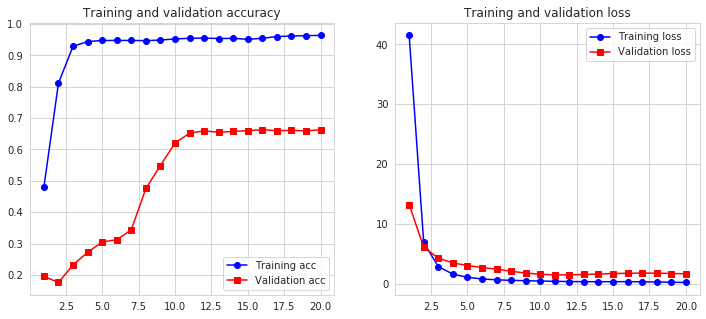

In [0]:
plot_history(conv_model)

In [0]:
train_pred = model.predict(X_tr)
test_pred = model.predict(X_ts)
print('train-acc = ' + str(accuracy_score(np.argmax(y_train_0, axis=1),
                                          np.argmax(train_pred, axis=1))))
print('test-acc = ' + str(accuracy_score(np.argmax(y_test_0, axis=1),
                                         np.argmax(test_pred, axis=1))))
# Compute confusion matrix
cm_train = confusion_matrix(np.argmax(y_train_0, axis=1),
                            np.argmax(train_pred, axis=1))
cm_test = confusion_matrix(np.argmax(y_test_0, axis=1),
                           np.argmax(test_pred, axis=1))

np.set_printoptions(precision=2)

train-acc = 0.9421845182987889
test-acc = 0.6616822429906543


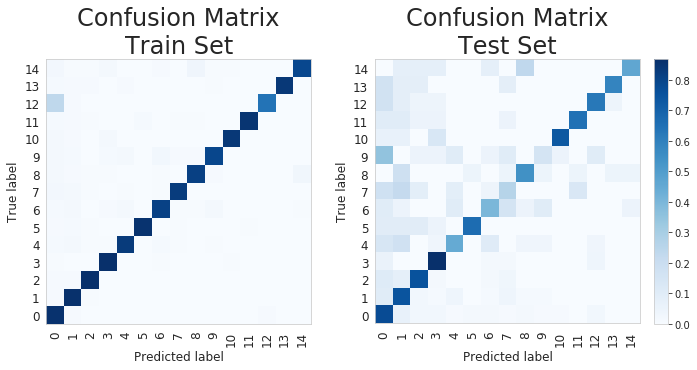

In [0]:
saving_as = os.path.join(path_to_data, 'confusion_matrix_conv1d.pdf')
plot_confusion_matrix(cm_train, cm_test, classes=class_d, saving_as, normalize=True)

In [0]:
check_predicted(model, 1000)

### BiLSTM: 

#### Hyperparameter tuning:

In [0]:
#Parameter tuning
def build_classifier(optimizer, dropout, nodes, layers):
    classifier = Sequential()
    classifier.add(Bidirectional
                   (CuDNNLSTM(nodes,
                              kernel_initializer='uniform',
                              kernel_regularizer=l2(0.01),
                              recurrent_regularizer=l2(0.01),
                              return_sequences=True,
                              input_shape=input_shape)))
    classifier.add(Bidirectional(CuDNNLSTM(nodes, return_sequences=True))) 
    classifier.add(Flatten())
    classifier.add(Dropout(dropout))
    classifier.add(Dense(nodes, activation='relu'))
    classifier.add(Dense(class_dim, activation='softmax'))
    classifier.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
    return classifier

parameters = {'batch_size': [64, 128, 256, 512],
              'epochs': [20, 30, 40],
              'optimizer': ['adam'],
              'dropout' : [0.25, 0.3, 0.5],
              'nodes' : [64, 128, 256],
              'layers' : [1, 2, 3, 4]}

#classifier = KerasClassifier(build_fn=build_classifier,
#                             epochs=10,
#                             batch_size=128,
#                             verbose=1)
#kfold = KFold(n_splits=5, shuffle=True)
#results = cross_val_score(classifier, X_train, y_train, cv=kfold)
#print(results.mean())

estimator = KerasClassifier(build_fn=build_classifier, verbose=1)
grid_search = GridSearchCV(estimator=estimator,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5, n_jobs=1, verbose=3)

grid_results = grid_search.fit(X_train, y_train)
best_parameters = grid_results.best_params_
best_accuracy = grid_results.best_score_
print('best_parameters: ', best_parameters)
print('best_accuracy: ', best_accuracy)


#### Model

In [0]:
input_shape = (X_tr.shape[1:])
print(input_shape)
batch_size = 256
epochs = 20
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Bidirectional(CuDNNLSTM(512,
                                  kernel_initializer='glorot_uniform',
                                  kernel_regularizer=l2(0.01),
                                  recurrent_regularizer=l2(0.01),
                                  return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(CuDNNLSTM(512, return_sequences=True)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(class_dim, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

(1, 8951)


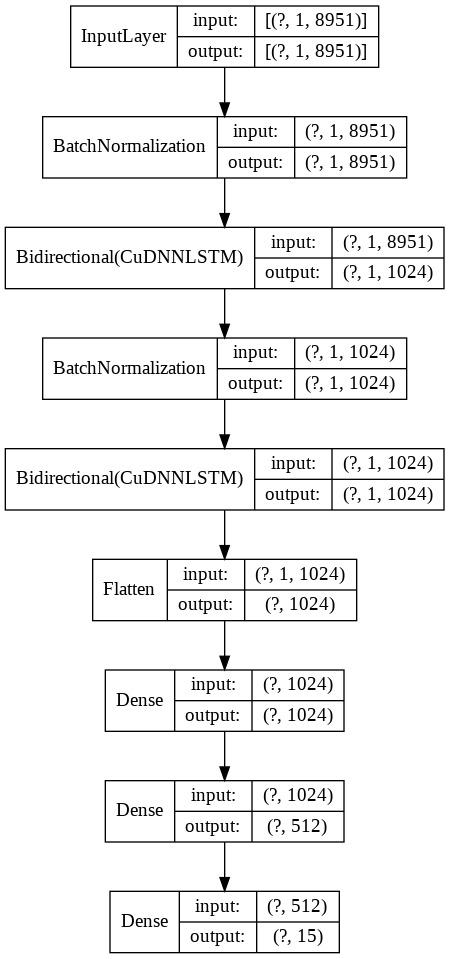

In [0]:
tf.keras.utils.plot_model(model,
                          to_file=os.path.join(path_to_data,'arch_lstm.png'),
                          show_shapes=True,
                          show_layer_names=False)

In [0]:
lstm_model = model.fit(X_tr, y_train_0,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_split=0.1,
                       #validation_data=(X_ts, y_test_0),
                       verbose=1)

In [0]:
plot_history(lstm_model)

In [0]:
train_pred = model.predict(X_tr)
test_pred = model.predict(X_ts)
print('train-acc = ' + str(accuracy_score(np.argmax(y_train_0, axis=1),
                                          np.argmax(train_pred, axis=1))))
print('test-acc = ' + str(accuracy_score(np.argmax(y_test_0, axis=1),
                                         np.argmax(test_pred, axis=1))))
# Compute confusion matrix
cm1 = confusion_matrix(np.argmax(y_train_0, axis=1), np.argmax(train_pred, axis=1))
cm2 = confusion_matrix(np.argmax(y_test_0, axis=1), np.argmax(test_pred, axis=1))
np.set_printoptions(precision=2)

train-acc = 0.7465655201080744
test-acc = 0.5677950252478025


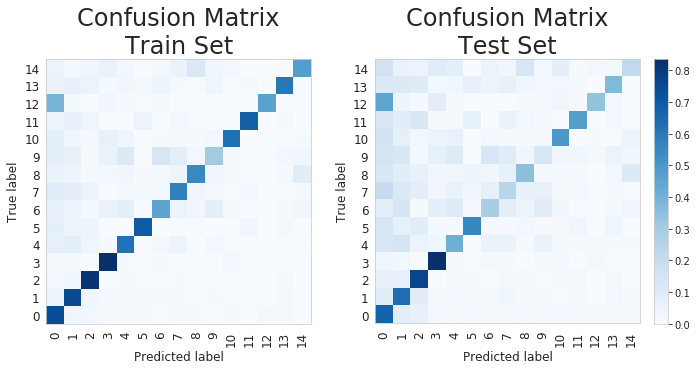

In [0]:
#Plot normalized confusion matrix
saving_as = os.path.join(path_to_data, 'confusion_matrix_lstm.pdf')
plot_confusion_matrix(cm1, cm2, class_d, saving_as, normalize=True)

In [0]:
plot_model(model, to_file='arch_lstm.png', show_shapes=True, show_layer_names=False)

In [0]:
check_predicted(model, 400)